In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
import os, sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
dev_name = 'HCI'
pg_path = '/content/drive/MyDrive/CodeData/[Packages]'+dev_name
sys.path.append(pg_path)

Mounted at /content/drive


In [12]:
import numpy as np
import scipy.io

m = scipy.io.loadmat('/content/drive/MyDrive/CodeData/HCI/data/BCICIV_calib_ds1d.mat', struct_as_record=True)

sample_rate = m['nfo']['fs'][0][0][0][0]
EEG = m['cnt'].T
nchannels, nsamples = EEG.shape

channel_name = [s[0] for s in m['nfo']['clab'][0][0][0]]
event_onsets = m['mrk'][0][0][0]
event_codes = m['mrk'][0][0][1]
labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
cl1 = cl_lab[0]
cl2 = cl_lab[1]
nclasses = len(cl_lab)
nevents = len(event_onsets)

print('shape of EEG:', EEG.shape)
print('sample rate:', sample_rate)
print('number of channels:', nchannels)
print('channel names:', channel_name)
print('number of event:', len(event_onsets))
print('event codes:', np.unique(event_codes))
print('class labels:', cl_lab)
print('number of classes:', nclasses)

shape of EEG: (59, 190473)
sample rate: 100
number of channels: 59
channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
number of event: 1
event codes: [-1  1]
class labels: ['left', 'right']
number of classes: 2


In [15]:
trials = {}
win = np.arange(int(0.5*sample_rate), int(2.5*sample_rate))

nsamples = len(win)

for cl, code in zip(cl_lab, np.unique(event_codes)):
  cl_onsets = event_onsets[event_codes==code]
  trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))

  for i, onset in enumerate(cl_onsets):
    trials[cl][:,:,i] = EEG[:, win+onset]

print('shape of trials[cl1]:', trials[cl1].shape)
print('shape of trials[cl2]:', trials[cl2].shape)

shape of trials[cl1]: (59, 200, 100)
shape of trials[cl2]: (59, 200, 100)


In [18]:
from matplotlib import mlab

def psd(trials):
  ntrials = trials.shape[2]
  trials_PSD = np.zeros((nchannels, 101, ntrials))

  for trial in range(ntrials):
    for ch in range(nchannels):
      (PSD, freqs)= mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
      trials_PSD[ch,:,trial] = PSD.ravel()

  return trials_PSD, freqs


In [19]:
psd_r, freqs = psd(trials[cl1])
psd_f, freqs = psd(trials[cl2])
trials_PSD = {cl1:psd_r, cl2:psd_f}

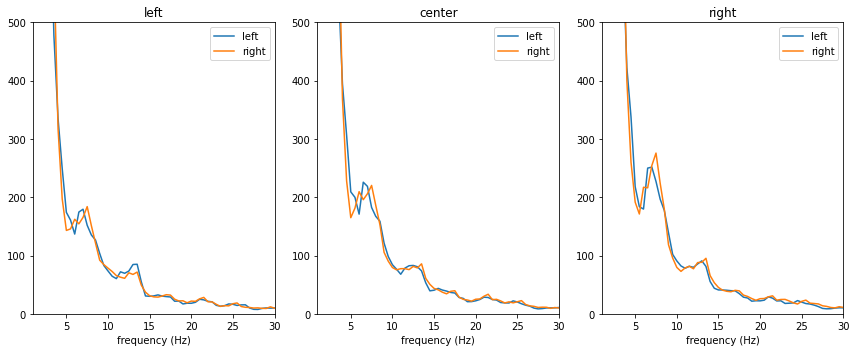

In [25]:
import matplotlib.pyplot as plt

def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
  plt.figure(figsize=(12, 5))
  nchans = len(chan_ind)

  nrows = int(np.ceil(nchans/3))
  ncols = min(3, nchans)

  for i, ch in enumerate(chan_ind):
    plt.subplot(nrows,ncols, i+1)

    for cl in trials.keys():
      plt.plot(freqs, np.mean(trials_PSD[cl][ch, :, :], axis=1), label=cl)

      plt.xlim(1, 30)
      if maxy != None:
        plt.ylim(0, maxy)

      plt.grid()
      plt.xlabel('frequency (Hz)')
      if chan_lab == None:
        plt.title('channel %d'%(ch+1))
      else: 
        plt.title(chan_lab[i])

      plt.legend()

  plt.tight_layout()

plot_psd(trials_PSD, freqs, [channel_name.index(ch) for ch in ['C3', 'Cz', 'C4']], 
         chan_lab=['left','center','right'], maxy=500)

In [32]:
import scipy.signal

def bandpass(trials, lo, hi, sample_rate):
  a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

  ntrials = trials.shape[2]
  trials_filt = np.zeros((nchannels, nsamples, ntrials))
  for i in range(ntrials):
    trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1)
  return trials_filt

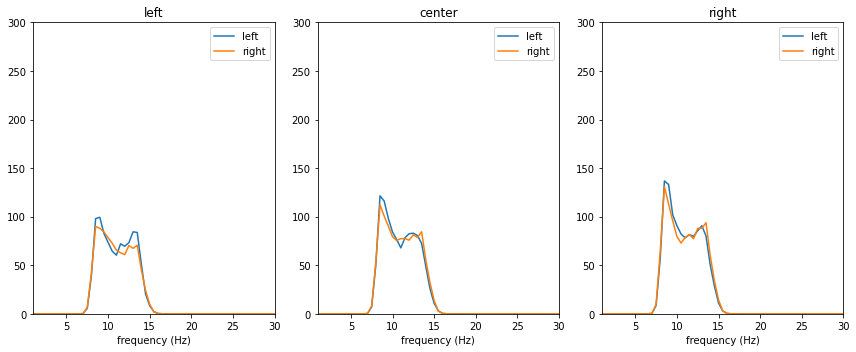

In [33]:
trials_filt = {cl1: bandpass(trials[cl1], 8, 15, sample_rate), cl2: bandpass(trials[cl2], 8, 15, sample_rate)}

psd_r, freqs = psd(trials_filt[cl1])
psd_f, freqs = psd(trials_filt[cl2])
trials_PSD = {cl1: psd_r, cl2:psd_f}

plot_psd(trials_PSD, freqs, [channel_name.index(ch) for ch in ['C3', 'Cz', 'C4']], 
         chan_lab=['left','center','right'], maxy=300)

In [37]:
def logvar(trials):
  return np.log(np.var(trials, axis=1))

trials_logvar = {cl1: logvar(trials_filt[cl1]), cl2: logvar(trials_filt[cl2])}

def plot_logvar(trials):
  plt.figure(figsize=(12,5))

  x0 = np.arange(nchannels)
  x1 = np.arange(nchannels)+0.4
  y0 = np.mean(trials[cl1], axis=1)
  y1 = np.mean(trials[cl2], axis=1)
  plt.bar(x0, y0, width=0.5, color='b')
  plt.bar(x1, y1, width=0.4, color='r')

  plt.xlim(-0.5, nchannels+0.5)

  plt.gca().yaxis.grid(True)
  plt.title('log-var of each channel/component')
  plt.xlabel('channels/components')
  plt.ylabel('log-var')
  plt.legend(cl_lab)


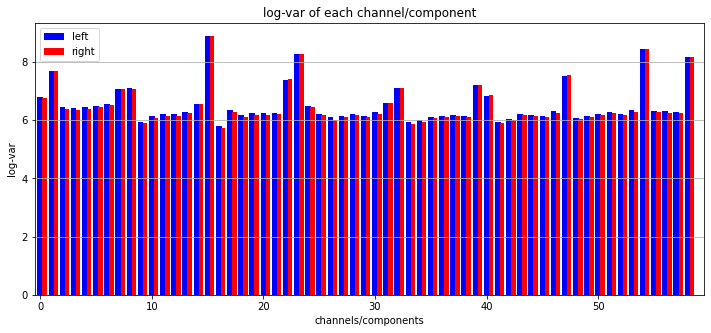

In [38]:
plot_logvar(trials_logvar)

In [39]:
from numpy import linalg

def cov(trials):
  ntrials = trials.shape[2]
  covs = [trials[:,:,i].dot(trials[:,:,i].T)/nsamples for i in range(ntrials)]
  return np.mean(covs, axis=0)

def whitening(sigma):
  U, I, _ = linalg.svd(sigma)
  return U.dot(np.diag(I**-0.5))

def csp(trials_r, trials_f):
  cov_r = cov(trials_r)
  cov_f = cov(trials_f)
  P = whitening(cov_r+cov_f)
  B, _, _ = linalg.svd(P.T.dot(cov_f).dot(P))
  W = P.dot(B)
  return W

def apply_mix(W, trials):
  ntrials = trials.shape[2]
  trials_csp = np.zeros((nchannels, nsamples, ntrials))
  for i in range(ntrials):
    trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
  return trials_csp

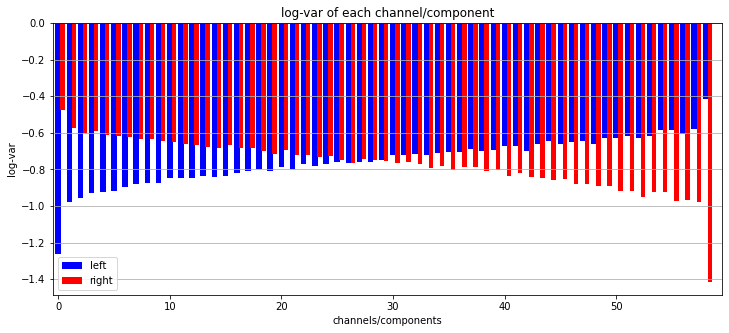

In [40]:
W = csp(trials_filt[cl1], trials_filt[cl2])
trials_csp = {cl1:apply_mix(W, trials_filt[cl1]), cl2:apply_mix(W, trials_filt[cl2])}
                            
trials_logvar = {cl1:logvar(trials_csp[cl1]), cl2:logvar(trials_csp[cl2])}
plot_logvar(trials_logvar)

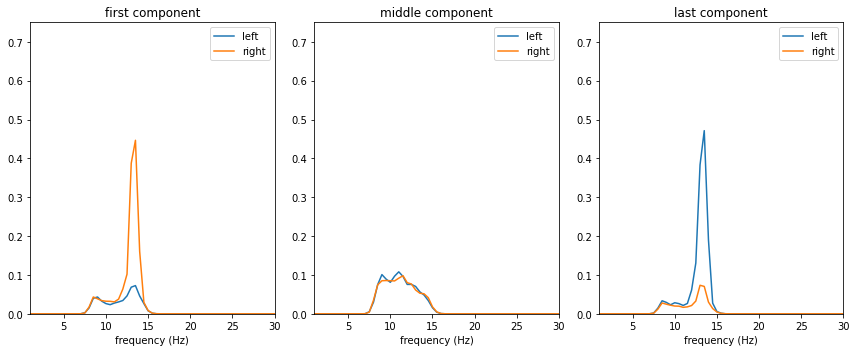

In [41]:
psd_r, freqs = psd(trials_csp[cl1])
psd_f, freqs = psd(trials_csp[cl2])

trials_PSD = {cl1: psd_r, cl2:psd_f}

plot_psd(trials_PSD, freqs, [0, 28, -1], chan_lab=['first component', 'middle component', 'last component'], maxy=0.75)


In [42]:
def plot_scatter(left, foot):
  plt.figure()
  plt.scatter(left[0,:], left[-1,:], color='b')
  plt.scatter(foot[0,:], foot[-1,:], color='r')
  plt.xlabel('last component')
  plt.ylabel('first component')
  plt.legend(cl_lab)

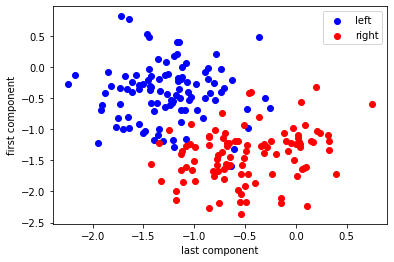

In [43]:
plot_scatter(trials_logvar[cl1], trials_logvar[cl2])